# Hybrid SE detection using Deep learning models

In [1]:
# Make sure dependecies are installed
!pip install wordcloud nltk imblearn matplotlib seaborn pandas numpy sklearn

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


## Fetch the data

In [2]:
!wget https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip
!wget https://raw.githubusercontent.com/npolatidis/seader/refs/heads/master/dialogues_dataset_formatted_added_links.csv

--2024-11-11 15:27:53--  https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘sms+spam+collection.zip’

sms+spam+collection     [ <=>                ] 198.65K  --.-KB/s    in 0.1s    

2024-11-11 15:28:02 (1.47 MB/s) - ‘sms+spam+collection.zip’ saved [203415]

--2024-11-11 15:28:02--  https://raw.githubusercontent.com/npolatidis/seader/refs/heads/master/dialogues_dataset_formatted_added_links.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28372 (28K) [text/plain]
Saving to: ‘dialogues_dataset_formatted

### First exploring the SMS Spam Collection

In [3]:
# Unzip the dataset
from zipfile import ZipFile

with ZipFile("sms+spam+collection.zip", 'r') as zip:
    zip.extractall()

In [4]:
!rm sms+spam+collection.zip

The dataset is a text file. So we can read in the different lines and convert the whole dataset into a DataFrame

In [5]:
data_dict = {'label':[], 'text': []}

with open("SMSSpamCollection", 'r') as file:
    for line in file:
        # Split the line on the first tab or whitespace
        parts = line.split(maxsplit=1)

        # Check that we have at least two parts: label and text
        if len(parts) == 2:
            label = parts[0].strip()
            text = parts[1].strip().strip('"')  # Remove surrounding quotes if any

            # Append to dictionary lists
            data_dict["label"].append(label)
            data_dict["text"].append(text)


In [6]:
# view a sample of the entries

for i in range(10):
    print(f"Label: {data_dict['label'][i]}, Text: {data_dict['text'][i]}")

Label: ham, Text: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Label: ham, Text: Ok lar... Joking wif u oni...
Label: spam, Text: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
Label: ham, Text: U dun say so early hor... U c already then say...
Label: ham, Text: Nah I don't think he goes to usf, he lives around here though
Label: spam, Text: FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv
Label: ham, Text: Even my brother is not like to speak with me. They treat me like aids patent.
Label: ham, Text: As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
Label: spam, Text: WINNER!! As a valued network customer 

In [7]:
# convert the dictionary to a dataframe
import pandas as pd

sms_df = pd.DataFrame(data_dict)
sms_df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
sms_df

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5569,spam,This is the 2nd time we have tried 2 contact u...
5570,ham,Will ü b going to esplanade fr home?
5571,ham,"Pity, * was in mood for that. So...any other s..."
5572,ham,The guy did some bitching but I acted like i'd...


In [9]:
sms_df.describe()

,label,text
count,5574,5574
unique,2,5160
top,ham,"Sorry, I'll call later"
freq,4827,30


In [10]:
sms_df.isnull().sum()

,0
label,0
text,0


In [11]:
sms_df.duplicated().sum()

414

In [12]:
# drop duplicated values
sms_df = sms_df.drop_duplicates(keep="first")

In [13]:
sms_df.duplicated().sum()

0

In [14]:
sms_df.shape

(5160, 2)

### Now to check out the Dialogues dataset

In [15]:
# read in csv file
import csv


dialogues_df = pd.read_csv("dialogues_dataset_formatted_added_links.csv", quoting=csv.QUOTE_NONE, on_bad_lines='skip', engine='python')
# TODO: error on line 69 - got 8 columns instead of 7
dialogues_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138 entries, 0 to 137
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   voice_id      138 non-null    int64 
 1   num_caller    138 non-null    int64 
 2   num_receiver  138 non-null    int64 
 3   date          138 non-null    int64 
 4   time          138 non-null    int64 
 5   is_attack     138 non-null    bool  
 6   dialog        138 non-null    object
dtypes: bool(1), int64(5), object(1)
memory usage: 6.7+ KB


In [16]:
dialogues_df.head()

,voice_id,num_caller,num_receiver,date,time,is_attack,dialog
0,4444444444,6094660035,9082456893,20050215,2050,False,This is mike smith from orange. I am a sales r...
1,5555555555,6094660036,9082456847,20050221,1254,False,Hi this is mike jones from orange. I am the sa...
2,3333333333,6094660038,9082456829,20050422,1315,True,I am john doe from apple computers where I am ...
3,2222222222,6094660035,9082456896,20050515,1150,True,This is john candy from apple. I am a computer...
4,1111111111,4879301873,9082456894,20050524,1433,False,hi this is moe sislack from moes tavern. I am ...


In [17]:
print(dialogues_df['is_attack'].value_counts())

is_attack
True     72
False    66
Name: count, dtype: int64


In [18]:
dialogues_df.describe()

,voice_id,num_caller,num_receiver,date,time
count,1.380000e+02,1.380000e+02,1.380000e+02,1.380000e+02,138.000000
mean,3.204443e+09,6.013426e+09,9.082457e+09,2.005654e+07,1263.007246
std,2.663748e+09,1.042616e+09,8.307955e+01,1.089949e+04,297.614297
min,1.010101e+09,4.247590e+09,9.082457e+09,2.002051e+07,834.000000
25%,1.111111e+09,4.879302e+09,9.082457e+09,2.005054e+07,1035.000000
50%,2.222222e+09,6.094660e+09,9.082457e+09,2.005567e+07,1244.000000
75%,4.166667e+09,6.094660e+09,9.082457e+09,2.006049e+07,1437.500000
max,1.000000e+10,8.542360e+09,9.082457e+09,2.013101e+07,2050.000000


In [19]:
sms_df['label'] = sms_df['label'].replace({'ham':'no', 'spam':'yes'})
sms_df.head()

<ipython-input-19-99b33286fd79>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sms_df['label'] = sms_df['label'].replace({'ham':'no', 'spam':'yes'})


,label,text
0,no,"Go until jurong point, crazy.. Available only ..."
1,no,Ok lar... Joking wif u oni...
2,yes,Free entry in 2 a wkly comp to win FA Cup fina...
3,no,U dun say so early hor... U c already then say...
4,no,"Nah I don't think he goes to usf, he lives aro..."


In [20]:
dialogues_df['is_attack'] = dialogues_df['is_attack'].replace({True:'yes', False:'no'})
dialogues_df.head()

,voice_id,num_caller,num_receiver,date,time,is_attack,dialog
0,4444444444,6094660035,9082456893,20050215,2050,no,This is mike smith from orange. I am a sales r...
1,5555555555,6094660036,9082456847,20050221,1254,no,Hi this is mike jones from orange. I am the sa...
2,3333333333,6094660038,9082456829,20050422,1315,yes,I am john doe from apple computers where I am ...
3,2222222222,6094660035,9082456896,20050515,1150,yes,This is john candy from apple. I am a computer...
4,1111111111,4879301873,9082456894,20050524,1433,no,hi this is moe sislack from moes tavern. I am ...


In [21]:
# our interest is in the labels and text
dialogues_df = dialogues_df.drop(['voice_id', 'num_caller', 'num_receiver', 'date', 'time'], axis=1)

In [22]:
dialogues_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138 entries, 0 to 137
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   is_attack  138 non-null    object
 1   dialog     138 non-null    object
dtypes: object(2)
memory usage: 2.3+ KB


In [23]:
# renaming colums
sms_df = sms_df.rename(columns={'label':'is_suspicious'})
dialogues_df = dialogues_df.rename(columns={'is_attack':'is_suspicious', 'dialog':'text'})

In [24]:
print(sms_df.columns)
print(dialogues_df.columns)

Index(['is_suspicious', 'text'], dtype='object')
Index(['is_suspicious', 'text'], dtype='object')


Combining both dataframe

In [25]:
combined_df = pd.concat([sms_df, dialogues_df], ignore_index=True)
combined_df

,is_suspicious,text
0,no,"Go until jurong point, crazy.. Available only ..."
1,no,Ok lar... Joking wif u oni...
2,yes,Free entry in 2 a wkly comp to win FA Cup fina...
3,no,U dun say so early hor... U c already then say...
4,no,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5293,yes,hi this is jenny heights from notre dame. I am...
5294,yes,hi this is your sales rep samuel pitt from roc...
5295,yes,hello I am a sales rep from orange. oh sorry b...
5296,yes,Hi this is justin jones I am a sales rep from ...


In [26]:
print(combined_df['is_suspicious'].value_counts())

is_suspicious
no     4584
yes     714
Name: count, dtype: int64


Checking the label distribution

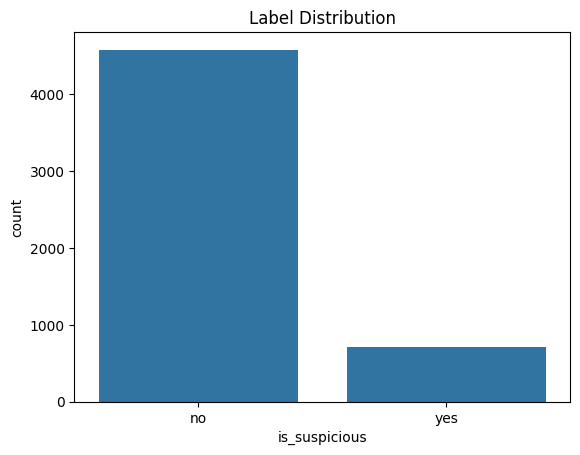

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='is_suspicious', data=combined_df)
plt.title("Label Distribution")
plt.savefig('./images/labels_distribution.png')
plt.show()

The dataset is greatly imbalanced as there are more instances of the non-suspicious class. This could affect the model as it could learn to favour the more common label. In a later cell, we will balance the dataset using a Synthetic Data Generation technique (ie Synthethic Minority Over-sampling Technique aka SMOTE)

Checking text length distribution|

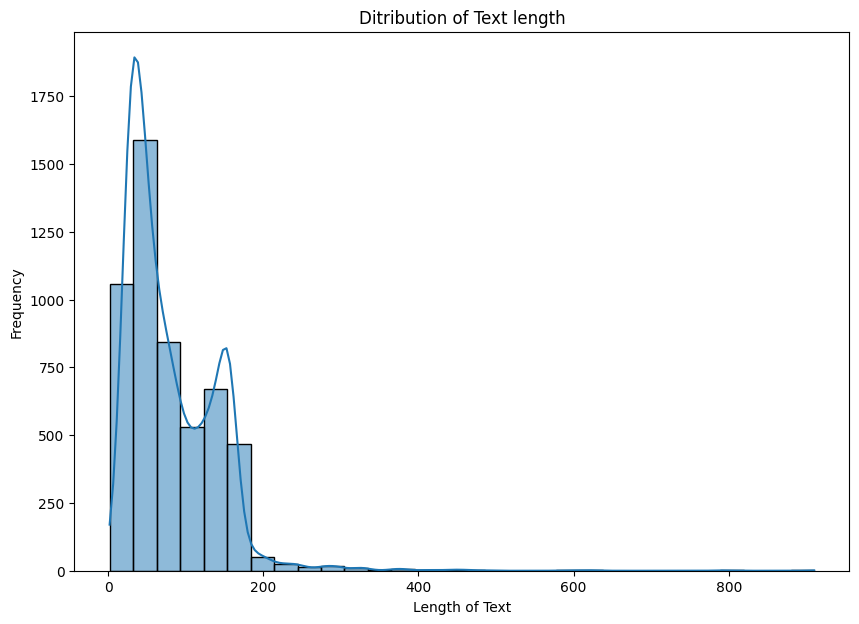

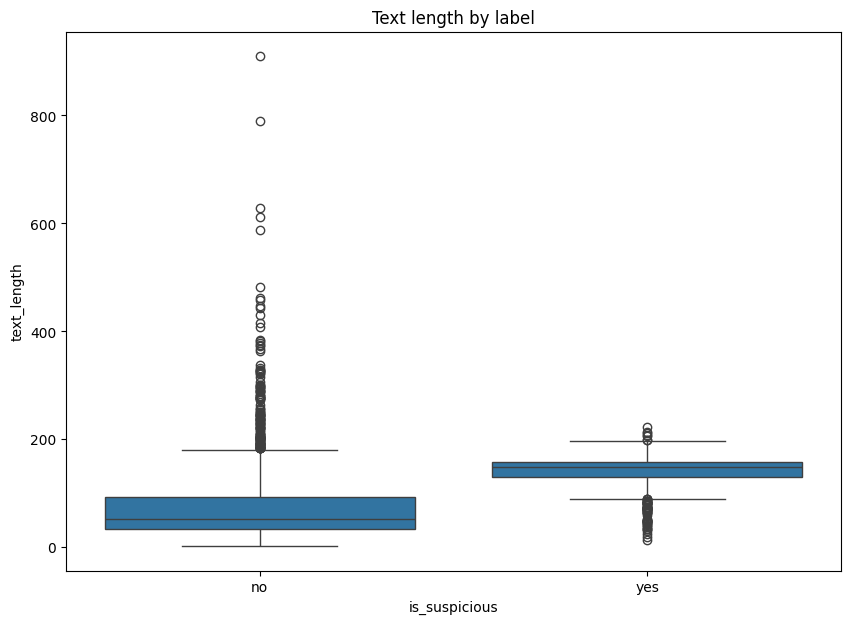

In [31]:
# new column
combined_df['text_length'] = combined_df['text'].apply(len)

# plot distribution
plt.figure(figsize=(10, 7))
sns.histplot(combined_df['text_length'], bins=30, kde=True)
plt.title("Ditribution of Text length")
plt.xlabel("Length of Text")
plt.ylabel("Frequency")
plt.savefig('images/text_length_by_frequency.png')
plt.show()

plt.figure(figsize=(10, 7))
sns.boxplot(x="is_suspicious", y='text_length', data=combined_df)
plt.title("Text length by label")
plt.savefig('images/text_length_by_label.png')
plt.show()

The histogram plot shows that most text the dataset contains are relatively short. The most common text length in the dataset is possibly betweeen 0 and 50 characters long.From the box plot we can see that although shorter messages correlate more with suspicious content. Non-suspicious messages also have short lengths, but they have more outliers that are longer than the majority

Checking Word Count and Average Words for each text

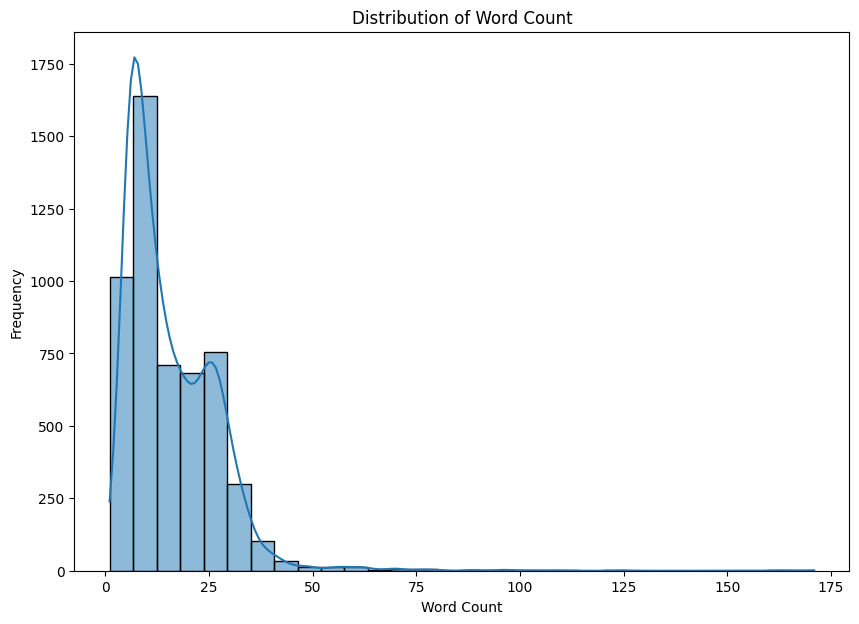

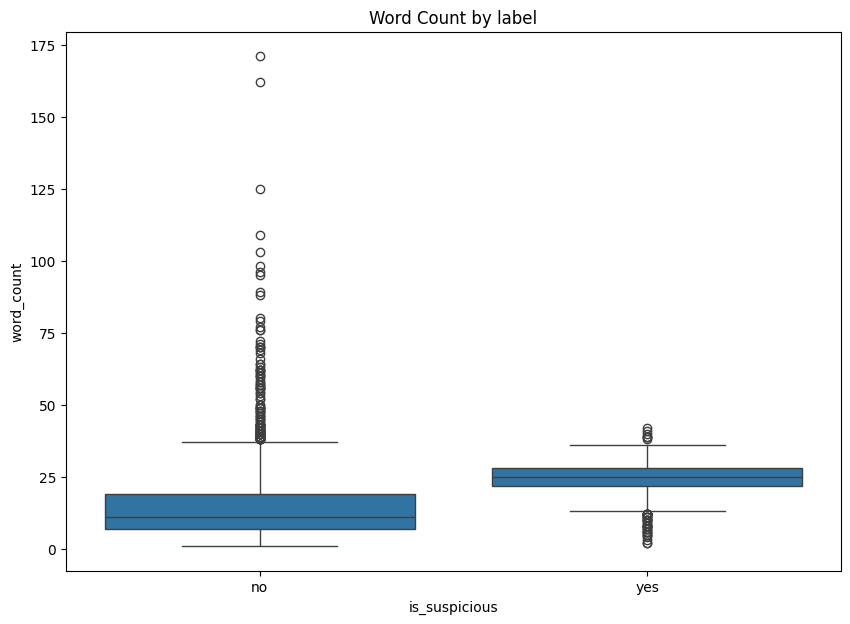

In [32]:
combined_df['word_count'] = combined_df['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 7))
sns.histplot(combined_df['word_count'], bins=30, kde=True)
plt.title("Distribution of Word Count")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.savefig('images/word_count_by_frequency.png')
plt.show()

# compare word count across labels
plt.figure(figsize=(10, 7))
sns.boxplot(x='is_suspicious', y='word_count', data=combined_df)
plt.title("Word Count by label")
plt.savefig('images/word_count_by_label.png')
plt.show()

Common word analysis using WordCloud

In [33]:
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter

# download stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [34]:
stop_words = set(stopwords.words('english'))

# function to join all text in a class and filter stop words
def create_word_cloud(label):
    text = " ".join(combined_df[combined_df['is_suspicious'] == label]['text'])
    filtered_words = " ".join([word for word in text.split() if word.lower() not in stop_words])
    wordcloud = WordCloud(width=600, height=300, background_color='white').generate(filtered_words)
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    if label == 'yes':
        plt.title("Word Cloud for Suspicious messages")
        plt.savefig('images/Suspicious_word_cloud.png')
    else:
        plt.title("Word Cloud for Not Suspicious messages")
        plt.savefig('images/Not_Suspicious_word_cloud.png')
    # plt.title(f"Word Cloud for {"Suspicious" if label == 'yes' else "Not suspicious"}")
    # plt.savefig(f'images/{"Suspicious" if label == 'yes' else "Not suspicious"}_word_cloud.png')
    plt.show()

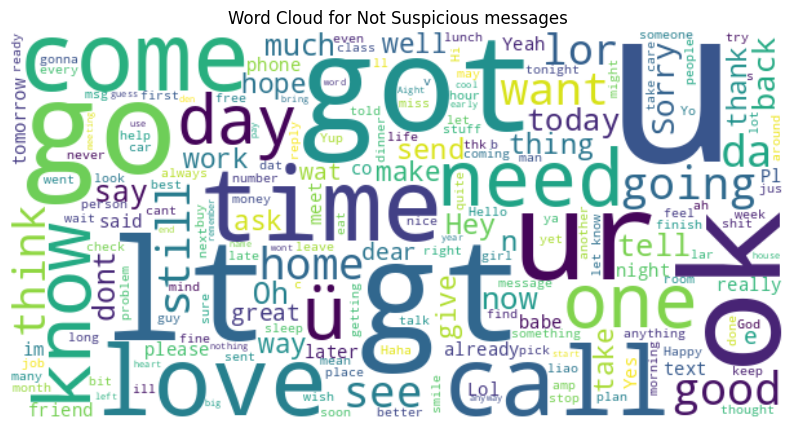

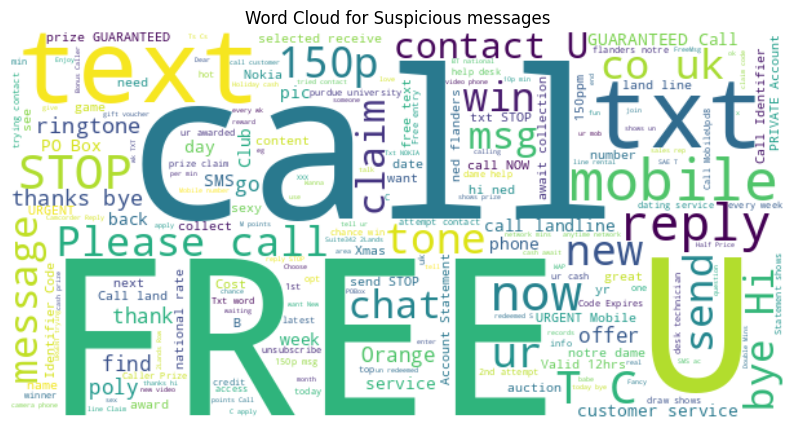

In [35]:
# Generate word clouds for each label
for label in combined_df['is_suspicious'].unique():
    create_word_cloud(label)

N-gram Analysis

In [36]:
from nltk import ngrams

def get_ngrams(text_series, n=2):
    all_ngrams = []
    for text in text_series:
        _ngrams = ngrams(text.split(), n)
        all_ngrams.extend(list(_ngrams))
    return Counter(all_ngrams).most_common(40)

# print top n-grams for each label
for label in combined_df['is_suspicious'].unique():
    # print(f"Top n-grams for {"Suspicious" if label == 'yes' else "Not suspicious"} messages: ")
    if label == 'yes':
        print("Top n-grams for Suspicious messages: ")
    else:
        print("Top n-grams for Suspicious messages: ")
    n_grams = get_ngrams(combined_df[combined_df['is_suspicious'] == label]['text'], 3)
    for gram, count in n_grams:
        print(f"{gram}: {count}")

Top n-grams for Suspicious messages: 
('I', 'am', 'a'): 46
('I', 'want', 'to'): 22
('would', 'you', 'like'): 22
('Hi', 'this', 'is'): 22
('I', 'miss', 'you'): 19
('you', 'like', 'to'): 17
('I', 'am', 'the'): 17
('sales', 'rep.', 'would'): 16
('rep.', 'would', 'you'): 16
('I', 'love', 'you'): 15
('.', '.', '.'): 15
('to', 'buy', 'some'): 15
('Do', 'have', 'a'): 14
('let', 'me', 'know'): 14
('give', 'me', 'a'): 14
('Have', 'a', 'great'): 14
('like', 'to', 'buy'): 14
('buy', 'some', 'software.'): 14
('to', 'go', 'to'): 13
('be', 'able', 'to'): 13
('I', 'have', 'to'): 13
('you', 'want', 'to'): 13
('a', 'great', 'day.'): 13
('Hope', 'you', 'are'): 13
('hi', 'this', 'is'): 13
('on', 'the', 'way'): 12
('I', 'need', 'you'): 12
('I', 'am', 'in'): 12
('How', 'are', 'you'): 12
('What', 'are', 'you'): 11
('Where', 'are', 'you'): 11
('a', 'sales', 'rep.'): 11
('?', 'Are', 'you'): 10
('?', 'Did', 'you'): 10
('let', 'you', 'know'): 10
('have', 'a', 'great'): 10
('text', 'me', 'when'): 10
('I', 'think

### Special character and URL analysis
Social engineering attacks tend to contain features like URLS or special characters and phrases to indicate ugency, we will be comparing the urgency features and url counts for both labels

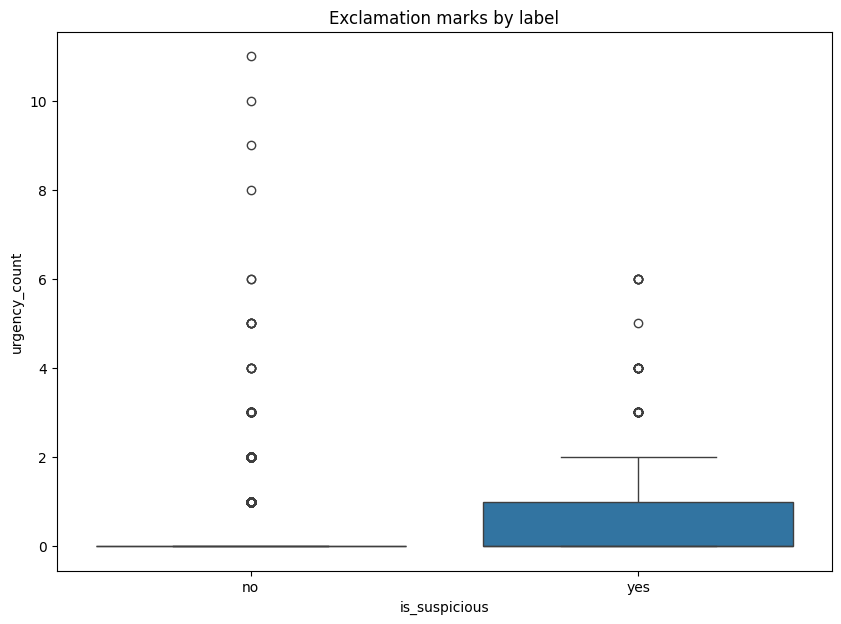

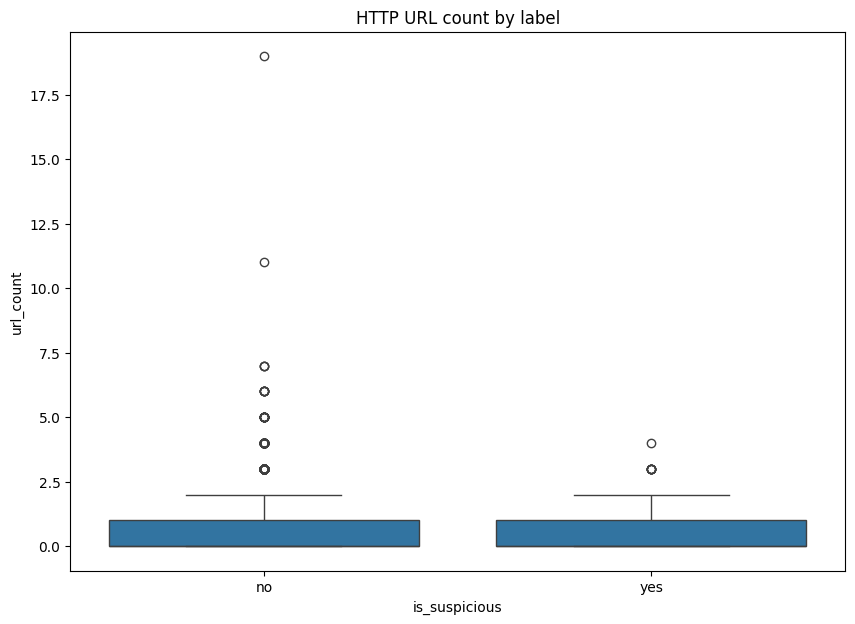

In [37]:
import re

combined_df['urgency_count'] = combined_df['text'].apply(lambda x: x.count('!') + x.lower().count('urgent') + x.lower().count('quick') + x.lower().count('asap'))
# combined_df["question_count"] = combined_df['text'].apply(lambda x: x.count('?'))

url_pattern = r'https?://[^\s]+|www\.[^\s]+|\S+\.\S+'
combined_df['url_count'] = combined_df['text'].apply(lambda x: len(re.findall(url_pattern, x)))
# combined_df['short_link_count'] =

plt.figure(figsize=(10,7))
sns.boxplot(x='is_suspicious', y='urgency_count', data=combined_df)
plt.title("Exclamation marks by label")
plt.savefig('images/urgency_count_by_labels.png')
plt.show()

plt.figure(figsize=(10,7))
sns.boxplot(x='is_suspicious', y='url_count', data=combined_df)
plt.title("HTTP URL count by label")
plt.savefig('images/url_count_by_label.png')
plt.show()


For this dataset, the suspicious messages contain more indications of urgency than non-suspicious messages. But for urls there are roughly the same in number.

### Correlation Analysis


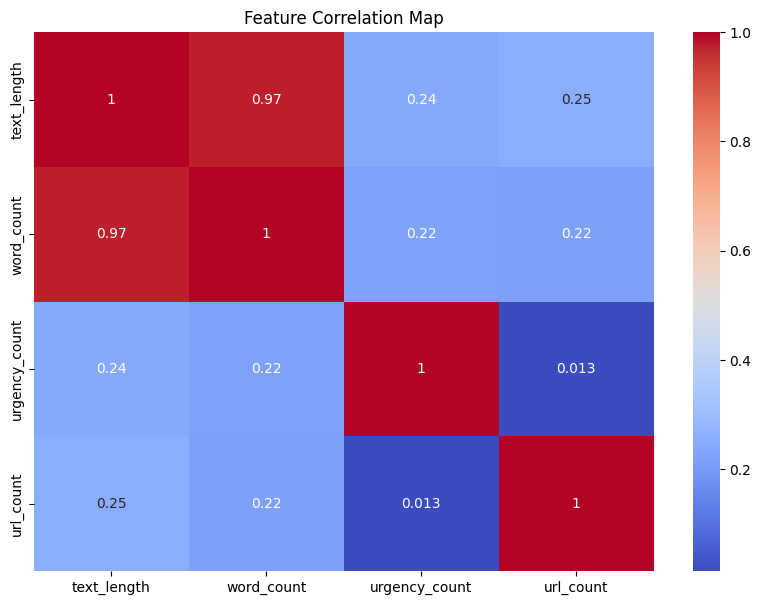

In [38]:
correlation_matrix = combined_df[['text_length', 'word_count', 'urgency_count', 'url_count']].corr()
plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Map")
plt.savefig('images/correlation_map.png')
plt.show()

Collecting the commen words and phrases are a labeled suspicious('yes') for use in our rule engine.

In [39]:
def clean_and_tokenize(text):
    text = re.sub(r'\W+', ' ', text).lower()  # this line removes non-alphanumeric characters and lower case
    return text.split()

suspicious_text = combined_df[combined_df['is_suspicious'] == 'yes']['text']
all_words = [word for text in suspicious_text for word in clean_and_tokenize(text)]

words_counts = Counter(all_words)
common_words = words_counts.most_common(100)

common_words = [word for word, _ in common_words if len(word) >= 4]
common_words

['call',
 'your',
 'free',
 'from',
 'this',
 'have',
 'with',
 'stop',
 'text',
 'mobile',
 'reply',
 'claim',
 'prize',
 'just',
 'only',
 'thanks',
 'send',
 'cash',
 '150p',
 'urgent',
 'please',
 'nokia',
 'service',
 'contact',
 'week',
 'phone',
 'will',
 'tone',
 'guaranteed',
 'been',
 'customer',
 'chat',
 'number',
 'help',
 '1000',
 'draw',
 'mins',
 'that',
 'awarded',
 'video',
 'line',
 'message']

In [40]:
# save words to a file
with open('common_suspicious_words.txt', 'w') as file:
    for word in common_words:
        file.write(f"{word}\n")

In [41]:
# Finding the common phrases
bigrams = get_ngrams(suspicious_text, 2)
bigrams

[(('I', 'am'), 81),
 (('this', 'is'), 74),
 (('am', 'a'), 54),
 (('You', 'have'), 34),
 (('to', 'contact'), 34),
 (('you', 'have'), 32),
 (('This', 'is'), 31),
 (('have', 'won'), 30),
 (('Hi', 'this'), 28),
 (('hi', 'this'), 25),
 (('or', 'a'), 23),
 (('won', 'a'), 22),
 (('will', 'be'), 22),
 (('your', 'mobile'), 21),
 (('for', 'your'), 21),
 (('can', 'you'), 21),
 (('Please', 'call'), 20),
 (('U', 'have'), 20),
 (('is', 'ned'), 19),
 (('ned', 'flanders'), 19),
 (('flanders', 'from'), 19),
 (('cash', 'or'), 18),
 (('You', 'are'), 18),
 (('attempt', 'to'), 18),
 (('from', 'notre'), 18),
 (('notre', 'dame.'), 18),
 (('to', 'receive'), 17),
 (('selected', 'to'), 17),
 (('with', 'a'), 17),
 (('have', 'a'), 17),
 (('dame.', 'I'), 17),
 (('To', 'claim'), 16),
 (('to', 'No:'), 16),
 (('prize', 'GUARANTEED.'), 16),
 (('GUARANTEED.', 'Call'), 16),
 (('URGENT!', 'Your'), 16),
 (('STOP', 'to'), 16),
 (('a', '£2000'), 16),
 (('PO', 'Box'), 15),
 (('2', 'claim'), 15)]

In [42]:
trigrams = get_ngrams(suspicious_text, 3)
trigrams

[(('I', 'am', 'a'), 54),
 (('Hi', 'this', 'is'), 28),
 (('hi', 'this', 'is'), 25),
 (('have', 'won', 'a'), 19),
 (('this', 'is', 'ned'), 19),
 (('is', 'ned', 'flanders'), 19),
 (('ned', 'flanders', 'from'), 19),
 (('from', 'notre', 'dame.'), 18),
 (('notre', 'dame.', 'I'), 17),
 (('dame.', 'I', 'am'), 17),
 (('prize', 'GUARANTEED.', 'Call'), 16),
 (('Account', 'Statement', 'for'), 15),
 (('university.', 'I', 'am'), 15),
 (('cash', 'or', 'a'), 14),
 (('from', 'land', 'line.'), 14),
 (('2nd', 'attempt', 'to'), 14),
 (('is', 'the', '2nd'), 14),
 (('flanders', 'from', 'notre'), 14),
 (('am', 'a', 'help'), 14),
 (('a', 'help', 'desk'), 14),
 (('help', 'desk', 'technician.'), 14),
 (('from', 'purdue', 'university.'), 14),
 (('purdue', 'university.', 'I'), 14),
 (('trying', 'to', 'contact'), 13),
 (('PRIVATE!', 'Your', '2003'), 13),
 (('Your', '2003', 'Account'), 13),
 (('2003', 'Account', 'Statement'), 13),
 (('£1000', 'cash', 'or'), 12),
 (('We', 'are', 'trying'), 12),
 (('are', 'trying', '

In [43]:
# save to file
with open("common_suspicious_phrases.txt", 'w') as file:
    for content in trigrams:
        file.write(f"{content[0][0]} {content[0][1]} {content[0][2]}")

## Testing the Rules Engine

In [44]:
# from suspicious_message_engine import SuspiciousMessageEngine

# engine = SuspiciousMessageEngine()

# dataset_text = combined_df["text"]
# # engine_preds = engine.predict(dataset_text[0])
# type(dataset_text[0])

In [45]:
# engine_preds = engine.predict(dataset_text[0])
# engine_preds

## Model building

### Building the base model: Logistic Regression model
Here we begin building our machine learning models. To begin, I create a baseline model and what ever results I get I try to beat in future models. Since I'll be using a Logistic Regression model as my baseline, I'll need to vectorize my text data, but also my dataset is greatly imbalanced. To prevent my model from being more biased on one label, i need to balance the dataset using SMOTE

In [46]:
# Import necessary libraries
from imblearn.over_sampling import SMOTE
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X = combined_df['text']
y = combined_df['is_suspicious']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)

# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vectorized, y_train)

# Check the distribution after resampling
print(pd.Series(y_train_resampled).value_counts())

is_suspicious
no     3663
yes    3663
Name: count, dtype: int64


In [47]:
X_train_resampled[0]

<1x7848 sparse matrix of type '<class 'numpy.float64'>'
	with 17 stored elements in Compressed Sparse Row format>

Now to building our baseline

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, accuracy_score, f1_score, precision_score

model = LogisticRegression(random_state=42)
model.fit(X_train_resampled, y_train_resampled)

LogisticRegression(random_state=42)

In [49]:
# Evaluate the model
X_test_vectorized = vectorizer.transform(X_test)  # vectorize the test dataset
y_pred = model.predict(X_test_vectorized)

In [50]:
print(f"Accuracy : {accuracy_score(y_test, y_pred)}")
print(f"F1-score : {f1_score(y_test, y_pred, pos_label='yes')}")
print(f"Precision : {precision_score(y_test, y_pred, pos_label='yes')}")
print(f"Recall : {recall_score(y_test, y_pred, pos_label='yes')}")


Accuracy : 0.9660377358490566
F1-score : 0.8714285714285714
Precision : 0.8652482269503546
Recall : 0.8776978417266187


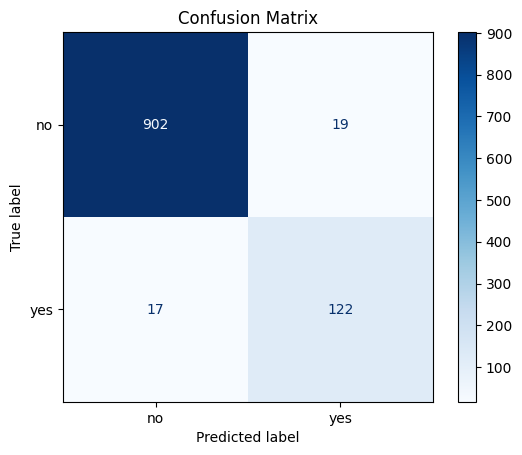

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create the confusion matrix
matrix = confusion_matrix(y_test, y_pred, labels=model.classes_)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

### Building the RNN

In [54]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

X = combined_df['text']
y = combined_df['is_suspicious']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [55]:
# checking my dataset's vocabulary
vectorizer.vocabulary_

{'do': 2395,
 'know': 4010,
 'what': 7568,
 'mean': 4450,
 'is': 3796,
 'the': 6895,
 'king': 3996,
 'of': 4934,
 'not': 4871,
 'havin': 3408,
 'credit': 2086,
 'goin2bed': 3216,
 'now': 4884,
 'night': 4821,
 'sweet': 6732,
 'only1more': 4992,
 'sleep': 6287,
 'come': 1921,
 'to': 7015,
 'mahal': 4356,
 'bus': 1582,
 'stop': 6570,
 'lt': 4293,
 'decimal': 2224,
 'gt': 3306,
 'wow': 7712,
 'love': 4270,
 'you': 7810,
 'sooo': 6398,
 'much': 4675,
 'can': 1643,
 'barely': 1232,
 'stand': 6512,
 'it': 3809,
 'wonder': 7673,
 'how': 3569,
 'your': 7815,
 'day': 2202,
 'goes': 3213,
 'and': 962,
 'if': 3644,
 'are': 1052,
 'well': 7547,
 'my': 4709,
 'think': 6928,
 'miss': 4549,
 'that': 6891,
 'desperate': 2289,
 'll': 4205,
 'just': 3930,
 'call': 1619,
 'armand': 1068,
 'again': 852,
 'da': 2159,
 'wil': 7608,
 'want': 7467,
 'new': 4801,
 'video': 7371,
 'phone': 5242,
 '750': 606,
 'anytime': 1006,
 'any': 996,
 'network': 4792,
 'mins': 4535,
 'half': 3349,
 'price': 5459,
 'line': 

In [60]:
vectorizer.get_feature_names_out()

array(['00', '000', '000pes', ..., 'zoom', 'èn', 'ú1'], dtype=object)

In [57]:
len(vectorizer.vocabulary_)

7848

In [62]:
# Building the Text Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

max_length = 50
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding='post', truncating='post')

In [64]:
from tensorflow.keras.utils import to_categorical

# categorically encode labels
y_train_encoded = to_categorical(y_train.map({'no': 0, 'yes': 1}))
y_test_encoded = to_categorical(y_test.map({'no': 0, 'yes': 1}))

In [76]:
from tensorflow.keras.layers import Attention, Conv1D, Input, GlobalMaxPooling1D
from tensorflow.keras.models import Model

# building the rnn
inputs = Input(shape=(max_length,))
x = Embedding(input_dim=5000, output_dim=128)(inputs)
x = Conv1D(64, 3, activation='relu')(x)
x = LSTM(128, return_sequences=True)(x)
x = Dropout(0.2)(x)
attention_output = Attention()([x, x])  # Self-attention
x = GlobalMaxPooling1D()(attention_output)  # Dimensionality reduction
x = Dense(64, activation='relu')(x)
outputs = Dense(2, activation='sigmoid')(x)

model = Model(inputs, outputs)

In [77]:
from tensorflow.keras.metrics import Precision, Recall

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', Precision(), Recall()])

In [78]:
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train_padded, y_train_encoded,
                    validation_data=(X_test_padded, y_test_encoded),
                    epochs=10,
                    # callbacks=[early_stopping],
                    batch_size=32)

Epoch 1/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.8545 - loss: 0.3748 - precision_2: 0.8546 - recall_2: 0.8545 - val_accuracy: 0.9755 - val_loss: 0.0757 - val_precision_2: 0.9755 - val_recall_2: 0.9755
Epoch 2/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9905 - loss: 0.0468 - precision_2: 0.9905 - recall_2: 0.9905 - val_accuracy: 0.9755 - val_loss: 0.0634 - val_precision_2: 0.9755 - val_recall_2: 0.9755
Epoch 3/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9924 - loss: 0.0252 - precision_2: 0.9924 - recall_2: 0.9924 - val_accuracy: 0.9774 - val_loss: 0.0719 - val_precision_2: 0.9765 - val_recall_2: 0.9783
Epoch 4/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9959 - loss: 0.0197 - precision_2: 0.9959 - recall_2: 0.9959 - val_accuracy: 0.9755 - val_loss: 0.0706 - val_precision_2: 0.9755 - val_recall_2: 0.9755
Epoch 5/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9958 - loss: 0.0175 - precision_2: 0.9958 - recall_2: 0.995

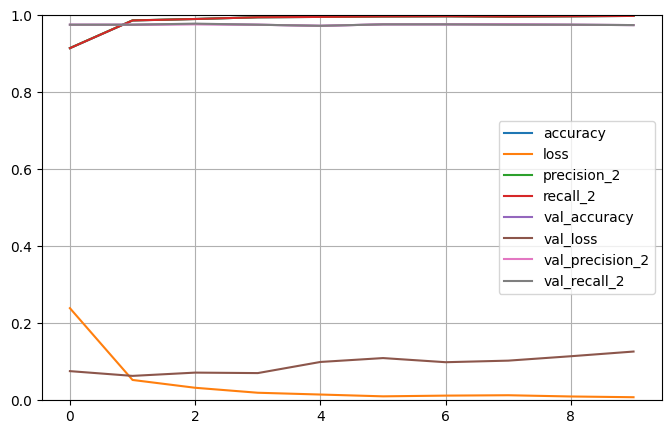

In [79]:
history_df = pd.DataFrame(history.history)
history_df.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()